# Assignment 2 - Bank Marketing

Link to the data: https://archive.ics.uci.edu/dataset/222/bank+marketing

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 

There are four datasets: 
1) bank.csv with 10% of the examples and 17 inputs, randomly selected from 3 (older version of this dataset with less inputs). 
2) bank-full.csv with all examples and 17 inputs, ordered by date (older version of this dataset with less inputs). 
3) bank-additional.csv with 10% of the examples (4119), randomly selected from 1), and 20 inputs.
4) bank-additional-full.csv with all examples (41188) and 20 inputs, ordered by date (from May 2008 to November 2010), very close to the data analyzed in [Moro et al., 2014]
The smallest datasets are provided to test more computationally demanding machine learning algorithms (e.g., SVM). 

The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y) by this research question:

'Which features of client demographics, marketing strategies, and external economic indicators most strongly influence the likelihood of subscribing to a bank term deposit?'


In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import seaborn as sns
import skfuzzy as fuzz
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [2]:
df_bank = pd.read_csv('Ass2Data\\bank\\bank.csv', delimiter=';')
df_bank_full = pd.read_csv('Ass2Data\\bank\\bank-full.csv', delimiter=';')
df_bank_additional = pd.read_csv('Ass2Data\\bank-additional\\bank-additional\\bank-additional.csv', delimiter=';')
df_bank_additional_full = pd.read_csv('Ass2Data\\bank-additional\\bank-additional\\bank-additional-full.csv', delimiter=';')
df_bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


Comparison between the 4 datasets
- df_bank: 4521 rows, 17 columns
- df_bank_full: 45211 rows, 17 columns

df_bank and df_bank_full have the same columns

- df_bank_additional: 4119 rows, 21 columns.
- df_bank_additional_full: 41188 rows, 21 columns.

Columns that are in the 'additional' datasets but not in the other 2: emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed

Our research question, as written in the report, is: **Which client demographics (age, job, marital status, etc.) have the most influence on whether or not a client subscribes to a term deposit?**

Therefore, we will first filter out the columns that are not related to the client demographics. We will then perform exploratory data analysis to understand the data better. Since the 'additional' datasets do not contain demographic variables, we will take a subset of the regular bank_full dataset.

In [3]:
demographic_variables = ['age', 'job', 'marital', 'education', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']
df_demo = df_bank_additional_full[demographic_variables]

Demographic variables: \
`age` (numeric) \
`job` : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown") \
`marital` : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed) \
`education` (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")

Social and economic context variables: \
`emp.var.rate`: employment variation rate - quarterly indicator (numeric) \
`cons.price.idx`: consumer price index - monthly indicator (numeric)     
`cons.conf.idx`: consumer confidence index - monthly indicator (numeric)
`euribor3m`: euribor 3 month rate - daily indicator (numeric) \
`nr.employed`: number of employees - quarterly indicator (numeric)   

# Advanced Exploratory Data Analysis 
Apply techniques from clustering and association rule mining domains.
- Data Cleaning: Outlier detection, summarizing dataset, descriptive stats, visualizations. Distribution of key variables
- AEDA: Scaling, normalization, one hot encoding, pair plots, correlation heatmaps
- Univariate and multivariate
- 2 clustering algorithms and evaluate them
- 2D plots, 3D plots
- association rules mining, evaluate them

## Data cleaning - iris
*[TODO] SCHRIJF INTRO DATA CLEANING*
### Difference between dataframes

In [4]:
# Define difference in columns
columns_diff = set(df_bank_additional_full.columns) - set(df_bank_full.columns)
print(columns_diff)

{'euribor3m', 'cons.conf.idx', 'emp.var.rate', 'day_of_week', 'cons.price.idx', 'nr.employed'}


Conclusion:

`df_bank_additional_full` contains the day of the week, and has the social and economic context attributes.

These attributes represent:

`emp.var.rate`: employment variation rate - quarterly indicator (numeric) \
`cons.price.idx`: consumer price index - monthly indicator (numeric)     
`cons.conf.idx`: consumer confidence index - monthly indicator (numeric)
`euribor3m`: euribor 3 month rate - daily indicator (numeric) \
`nr.employed`: number of employees - quarterly indicator (numeric)

### Null values

Next, we will check for potential null values in our dataset. As mentioned in the data description: " _There are several missing values in some categorical attributes, all coded with the "unknown" label. These missing values can be treated as a possible class label or using deletion or imputation techniques._ "


In [5]:
#Check for values encoded with the 'unknown' label
df_demo.replace('unknown', np.nan, inplace=True);
df_demo.isnull().sum()

C:\Users\20201222\AppData\Local\Temp\ipykernel_30488\2746681656.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demo.replace('unknown', np.nan, inplace=True);


age                  0
job                330
marital             80
education         1731
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

Now, we are going to examine the data to see if the rows that contain missing values (NaNs) have a higher tendency to have "yes" or "no" in a specific column.

In [6]:
# Count the number of NaN values in each column for y = yes and y = no
nan_counts = df_demo[df_demo[['job', 'marital', 'education']].isna().any(axis=1)].groupby('y').agg(
    job_nan=('job', lambda x: x.isna().sum()),
    marital_nan=('marital', lambda x: x.isna().sum()),
    education_nan=('education', lambda x: x.isna().sum()),
).reset_index()

# Add the total counts of y values
y_counts = df_demo['y'].value_counts().reset_index()
y_counts.columns = ['y', 'y_count']

# Merge the NaN counts with the total counts
nan_counts = nan_counts.merge(y_counts, on='y')

# Display the table
nan_counts

,y,job_nan,marital_nan,education_nan,y_count
0,no,293,68,1480,36548
1,yes,37,12,251,4640


The missing values have a higher tendency to have a "no" value for y. However, the "yes/no" ratio is not that different from the original ratio of the y values.

The total amount rows with 'unknown' values for either job or education come down to about 5% of the total data. Since this is a small percentage, and the "yes/no" ratio is not dissimilar from the original y value counts, we have decided to drop these rows.

In [7]:
#Drop rows with missing values
pre = df_demo.shape[0]
df_demo.dropna(inplace=True);
post = df_demo.shape[0]

print('Deleted rows: ', pre - post)
df_demo.isnull().sum()

Deleted rows:  1997


C:\Users\20201222\AppData\Local\Temp\ipykernel_30488\1969627028.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demo.dropna(inplace=True);


age               0
job               0
marital           0
education         0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

### Define numerical and categorical columns

In [8]:
# Extract numerical column names
numerical_columns = df_demo.select_dtypes(include=['number']).columns.tolist()

# Extract categorical column names
categorical_columns = df_demo.select_dtypes(include=['object']).columns.tolist()

print("Numerical columns:", numerical_columns)
print("Categorical columns:", categorical_columns)

categorical_columns.remove('y') #Remove the target variable

Numerical columns: ['age', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
Categorical columns: ['job', 'marital', 'education', 'y']


### Data distribution and outliers

In [9]:
#show summary statistics for (numerical) data
df_demo[numerical_columns].describe(include='all')

,age,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,39191.000000,39191.000000,39191.00000,39191.000000,39191.000000,39191.000000
mean,39.858003,0.083238,93.57172,-40.537146,3.623633,5167.404340
std,10.288300,1.566502,0.57705,4.621895,1.730493,71.787741
min,17.000000,-3.400000,92.20100,-50.800000,0.634000,4963.600000
25%,32.000000,-1.800000,93.07500,-42.700000,1.344000,5099.100000
50%,38.000000,1.100000,93.44400,-41.800000,4.857000,5191.000000
75%,47.000000,1.400000,93.99400,-36.400000,4.961000,5228.100000
max,98.000000,1.400000,94.76700,-26.900000,5.045000,5228.100000


*Conclusions summary statistics*

- The average age is 39.858 years old. 
- The variation rate of employment is very low with an average of 0.083238. 
- The index of the consumption price is over 90, indicating that the inflation is stable. 
- The confidence of consumption is negative; the average value is -40.537146. This means people are not optimistic about the economy. 
- Euribor3m is 3.623633; it means the interest rate is not very high. 
- The number of employees is around 5167.404340. 
 
While the data is indicative of a relatively stable economic state of the country, on the other hand, the consumption confidence index is negative, which means the consumers do not feel optimistic about the future. This may become indicative of the fact that the economy is not growing as fast as it should.

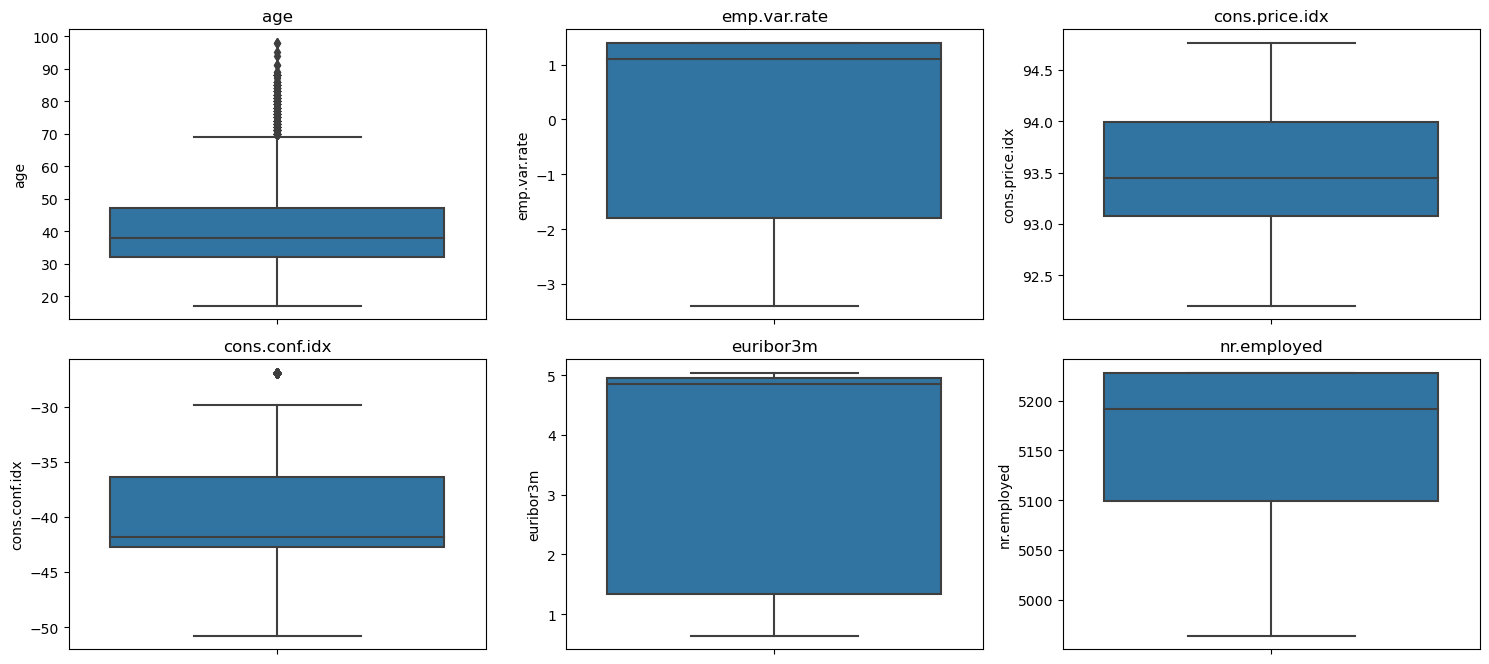

In [10]:
# create a figure with barplot subplots
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns)//3 + 1, 3, i)
    sns.boxplot(y=df_demo[feature], showfliers=True)
    plt.title(feature)
plt.tight_layout()
plt.show()


It appears only `age` has some outliers. To even better undertsan dthe data, we make some histograms.

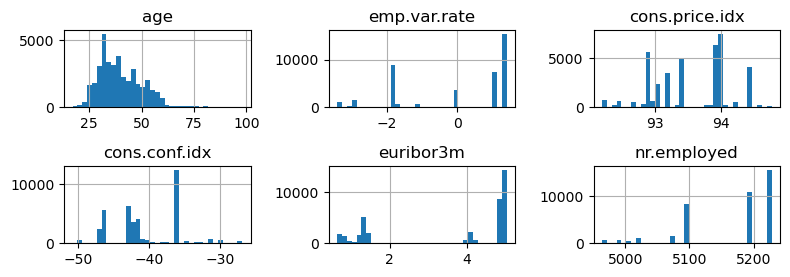

In [11]:
# create a figure with histogram subplots
plt.figure(figsize=(8, 4))
for i, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns)//3 + 1, 3, i)
    df_demo[feature].hist(bins=35)
    plt.title(feature)
plt.tight_layout()
plt.show()

*Conclusions data distributions*

*[TODO] CONCLUSIONS NALEZEN*

- Age: Most of the customers are in their 30s and 40s, but some reach as high as 90 years old. The distribution is slightly right skewed.
- emp.var.rate: The employment variation rate is centred around 0, with a slight negative bias and a smaller negative range than positive. This might indicate that there is a period of low growth in employment with some upswings. 
- cons.price.idx: Consumer price index is changes within a narrow band around 93. It reflects very low level of inflation. 
- cons.conf.idx: The consumer confidence index slightly stands on the negative side, as the majority of the values are around -40 with a small range, having some outliers below -30. 
- euribor3m: The Euribor 3-month interest rate has been steady at about 4.5%, with a small range-a sign of the financial market's relative stability. 
- nr.employed: The range of employees is relatively the same, around 5150, with a slight increase.

## Feature engineering - iris

*[TODO] SCHRIJF INTRODUCTIE FEATURE ENGINEERING*

### Normalize numerical columns

Since the numerical clumns are not highly skewed, we decieded to not normalize them.

### Label encoding of categorical features

The categorical variables all contains string values. These are hard to process for clustering or modeling algorithms. Therefore, they should be encoded.

Considering one-hot encoding would result in a large amount of extra columns, we decided to use label encoding.

In [12]:
from sklearn.preprocessing import LabelEncoder

df_demo_encoded = df_demo #Copy dataset for encoding

# Apply label encoding to categorical columns
label_mappings = {}

for column in categorical_columns:
    le = LabelEncoder()
    ids = le.fit_transform(df_demo_encoded[column])
    df_demo_encoded[column] = ids
    mapping = dict(zip(le.classes_, range(len(le.classes_))))
    label_mappings.update(mapping)

#Encode the target variable
df_demo_encoded['y'] = df_demo_encoded['y'].map({'yes': 1, 'no': 0})
print(label_mappings)

{'admin.': 0, 'blue-collar': 1, 'entrepreneur': 2, 'housemaid': 3, 'management': 4, 'retired': 5, 'self-employed': 6, 'services': 7, 'student': 8, 'technician': 9, 'unemployed': 10, 'divorced': 0, 'married': 1, 'single': 2, 'basic.4y': 0, 'basic.6y': 1, 'basic.9y': 2, 'high.school': 3, 'illiterate': 4, 'professional.course': 5, 'university.degree': 6}


C:\Users\20201222\AppData\Local\Temp\ipykernel_30488\3881851478.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demo_encoded[column] = ids
C:\Users\20201222\AppData\Local\Temp\ipykernel_30488\3881851478.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demo_encoded[column] = ids
C:\Users\20201222\AppData\Local\Temp\ipykernel_30488\3881851478.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

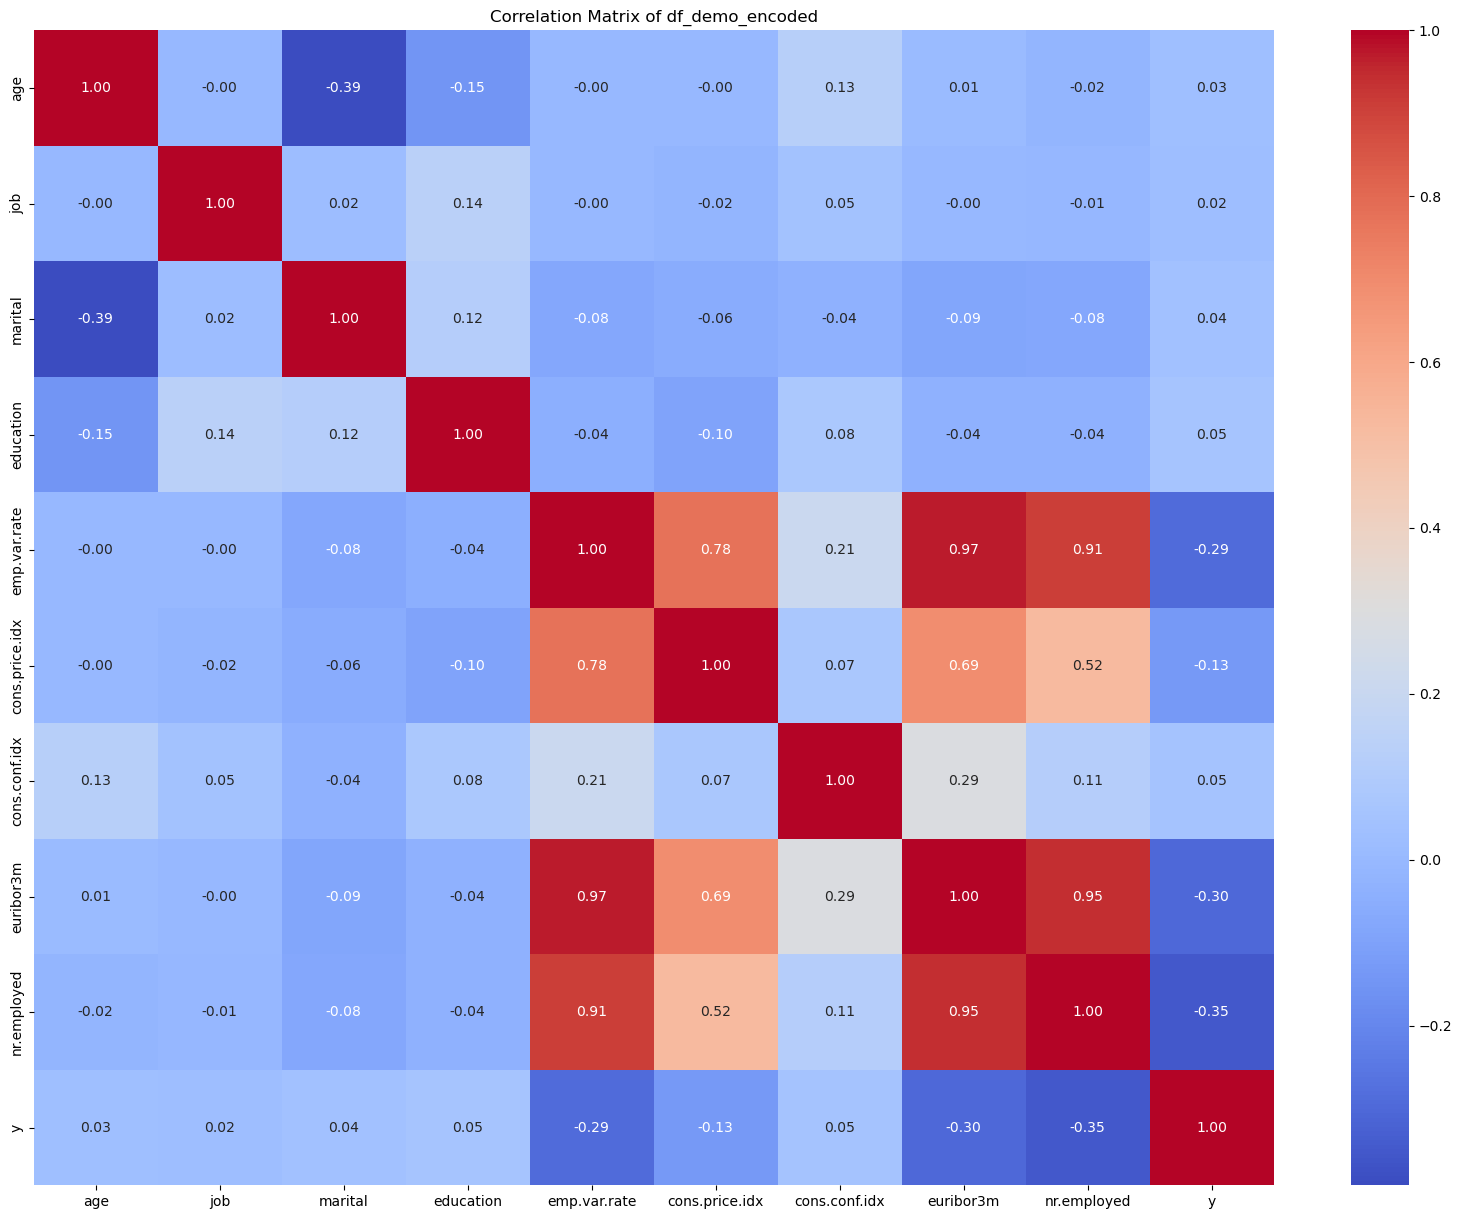

In [13]:
# Calculate the correlation matrix
correlation_matrix = df_demo_encoded.corr()

# Plot the heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of df_demo_encoded')
plt.show()

*[TODO] Uitleg en conclusie schrijven over correlation matrix*

In [14]:
# Calculate the correlation matrix for the target variable 'y' and other features
y_corr = df_demo_encoded.corr()[['y']]

print(y_corr)

                       y
age             0.030557
job             0.020840
marital         0.041972
education       0.054412
emp.var.rate   -0.293264
cons.price.idx -0.133833
cons.conf.idx   0.051365
euribor3m      -0.302094
nr.employed    -0.349526
y               1.000000


We are interested in which variables correlate with the target variable the most, therefore, we select all correlations with `y` and sort the absolute balues from high to low. We sort on absolute values because of the fact a negative effect is also an effect we would like to know.

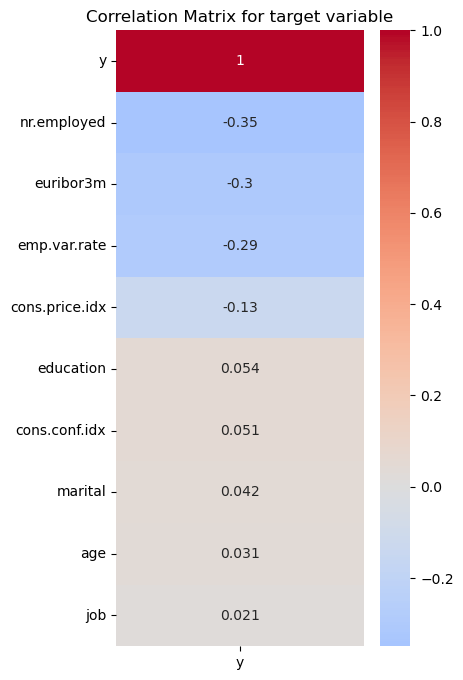

In [15]:
# Filter the correlation matrix for y_no and y_yes where the absolute value of correlation is higher than 0.1
#filtered_corr_matrix = y_corr[(y_corr['y_yes'].abs() > 0.1)]
filtered_corr_matrix = y_corr

#Sort the values by the absolute value of correlation for visualization purposes
filtered_corr_matrix = filtered_corr_matrix.reindex(filtered_corr_matrix['y'].abs().sort_values(ascending=False).index)

# Plot the heatmap for the filtered correlation matrix
plt.figure(figsize=(4, 8))
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix for target variable')
plt.show()

*[TODO] CONCLUSIE SCHRIJVEN OVER CORRELATION MATRIX*

In [ ]:
# Create pair plots
# sns.pairplot(df_demo_encoded[key_features])
# plt.show()

Ik denk dat deze pair plot overbodig is, geeft ons vgm niet veel extra informatie
- Onno

### Sampling considerations
There are way more y_no than y_yes. We have decided NOT to resample this, and instead use the imbalanced dataset. We will evaluate the models based on the AUC, which is a better metric for imbalanced datasets. This will also be explained later in the notebook.

In [ ]:
# Separate majority and minority classes
df_majority = df_demo_encoded[df_demo_encoded['y'] == 0]
df_minority = df_demo_encoded[df_demo_encoded['y'] == 1]
print("Succesfull calls (Subscriptions to term deposit, y=1):", df_minority.shape[0])
print("Unsuccesfull calls (no subscription, y=0):", df_majority.shape[0])

## Clustering

In this section, we will be applying two clustering algorithms to the data: DBSCAN and Fuzzy C-Means Clustering. We chose to use DBSCAN because we saw from the EDA that we have a lot of outliers in our attributes. The decision for Fuzzy C-Means Clustering was made as we expect high overlap between the clusters, which this clustering method works well for.

In [ ]:
df_demo_encoded_no_y = df_demo_encoded.drop(columns=['y'])
df_demo_encoded_no_y.head()

### Cluster algorithm 1 - DBSCAN

In [ ]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
 
neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(df_demo_encoded_no_y)
distances, indices = neighbors_fit.kneighbors(df_demo_encoded_no_y)
distances = np.sort(distances, axis=0)[:,1]


In [ ]:
plt.xlim(30000, 39300)
plt.axhline(y=3, color='r', linestyle='--')
plt.plot(distances)

In [ ]:

#------------- AURELIA NOG AANPASSEN OM NIET HARDCODED TE ZIJN -----------------
# # Define a range of eps and min_samples values to test
# eps_values = np.arange(5, 10, 0.2)  # Adjust the range and step as necessary
# min_samples_values = range(9, 19)

# # Dictionary to store the results
# best_score = -1
# best_params = {}

# for eps in eps_values:
#     for min_samples in min_samples_values:
#         # Apply DBSCAN
#         dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#         labels = dbscan.fit_predict(df_demo_encoded_no_y)
        
#         # Only compute silhouette score if there is more than 1 cluster
#         if len(set(labels)) > 1:
#             score = silhouette_score(df_demo_encoded_no_y, labels)
#             print(f"eps: {eps}, min_samples: {min_samples}, silhouette score: {score}")
            
#             # Check if this is the best score
#             if score > best_score:
#                 best_score = score
#                 best_params = {'eps': eps, 'min_samples': min_samples}

# print(f"Best params: {best_params}, Best silhouette score: {best_score}")

In [ ]:
# Run DBSCAN clustering
dbscan = DBSCAN(eps=8.2, min_samples=9)  # Values based on previous cell
df_demo_encoded['dbscan_cluster'] = dbscan.fit_predict(df_demo_encoded_no_y)

In [ ]:
sum(df_demo_encoded['dbscan_cluster'].unique())

In [ ]:
df_demo_encoded.columns

In [ ]:
# Plot the pairplot with hue based on the 'y' labels
sns.pairplot(df_demo_encoded, vars=df_demo_encoded.columns, 
             hue='y')  # 1 is yes, 0 is no
plt.suptitle("Pairplot Colored by 'y' Labels", y=1.02)
plt.show()

In [ ]:
# Plot the pairplot with hue based on the DBSCAN clusters
sns.pairplot(df_demo_encoded, vars=df_demo_encoded_no_y.columns, 
             hue='dbscan_cluster', palette='tab10')
plt.suptitle("Pairplot Colored by DBSCAN Clusters", y=1.02)
plt.show()

### Cluster algorithm 2  - Fuzzy C-Means Clustering

In [ ]:
# Defining the cluster_range and accuracies for plotting process
cluster_range = range(1,11)
accuracies = []
all_clusters = []
data = df_demo_encoded_no_y

# Perform Fuzzy C-Means clustering for each number of clusters
for n_clusters in cluster_range:
    # Perform fuzzy C-means clustering
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data.T, n_clusters, 2, error=0.005, maxiter=1000)
    
    # Assign clusters based on the highest membership
    clusters = np.argmax(u, axis=0)
    all_clusters.append(clusters)

print(all_clusters)

In [ ]:
from sklearn.metrics import confusion_matrix

true_labels = df_demo_encoded['y']

# Calculate accuracies for each clustering result
for clusters in all_clusters:
    # Using sklearn's confusion_matrix to generate the contingency matrix
    contingency_matrix = confusion_matrix(true_labels, clusters)
    
    # For each cluster, find the maximum true label count
    correct_predictions = sum(np.max(contingency_matrix, axis=0))

    # Calculate accuracy
    accuracy = correct_predictions / len(true_labels)
    accuracies.append(accuracy)


# Perform fuzzy c-means clustering with 4 clusters
n_clusters_4 = 4
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data.T, n_clusters_4, 2, error=0.005, maxiter=1000)
clusters4 = np.argmax(u, axis=0)

# Add the cluster assignment to the dataframe
df_demo_encoded['fuzzy_cluster'] = clusters4

# Plotting number of clusters vs. accuracy
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, accuracies, marker='o', color='b', label="Accuracy")
plt.title("Number of Clusters vs. Accuracy")
plt.xlabel("Number of Clusters")
plt.ylabel("Accuracy")
plt.xlim(0, 11)  # Setting x-axis limit
plt.ylim(0, 1.1)  # Setting y-axis limit
plt.xticks(range(0, 12))  # Setting x-ticks every 1 increment
plt.yticks(np.arange(0, 1.1, 0.1))  # Setting y-ticks every 0.1 increment
plt.grid()
plt.legend()

# Plot the clusters using pairplot
sns.pairplot(df_demo_encoded, vars=df_demo_encoded_no_y.columns, hue='fuzzy_cluster', palette='viridis')
plt.show()

# Print final clustering accuracy
print("Clustering Accuracies:", accuracies)

In [ ]:
# return cluster centers cntr 
print(f"Clusters centers: {cntr}")
# return membership matrix u
print(f"Memership matrix: {u}")

## Association rules

In [ ]:
df_ass_rules = df_demo_encoded
df_ass_rules = df_ass_rules.drop(['duration', 'pdays'], axis=1)
df_ass_rules

Implementation of Apriori

In [ ]:
df_ass_rules

In [ ]:
#I don't know why, but although this results in the exact same df it won't run without it
def encode(item_freq):
    res = 0
    if item_freq > 0:
        res = 1
    return res
    
basket_input = df_ass_rules.applymap(encode)

In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules

# Write your code for Association rules with 10% support and 20% confidence
frequent_items = apriori(basket_input, min_support=0.1, use_colnames=True)
frequent_items

In [ ]:
# with 20% Confidence
rules = association_rules(frequent_items, metric='confidence', min_threshold=0.20)
rules

In [ ]:
# Order the most frequent item combinations in the entire dataset, by sorting the dataset by support, confidence, and lift
rules_sorted = rules.sort_values(["support", "confidence","lift"],axis = 0, ascending = False)
rules_sorted

We find that all the rules have a positive lift, meaning that they're good influential rules. The rules are sorted based importance.

The antecedents explain the consequents, as we are interested in explaining the y_yes variable, which indicates whether someone has received a loan or not, we will only be looking at those.

In [ ]:
# Done manually because of frozenset
rules_sorted = rules_sorted.drop([5, 0, 1, 3, 7, 8, 11])
rules_sorted

We find that that:"
1. given someone has cellular contact, there's a 39.55% chance they receive a loan.
2. Given someoen has previously received a loan, there's a 17.26% chance they receive a loan.
3. Given that they both have cellular contact, and received a loan previously, there's a 15.49% chance they receive a loan.
4. 5. TODO: debate whether these are necessary.

Visalising the confidence

In [ ]:
rules

In [ ]:
# Create a bar plot for confidence values
plt.figure(figsize=(10, 6))
sns.barplot(x='confidence', y='antecedents',  data=rules)

# Add title and labels
plt.title('Confidence of Association Rules', fontsize=14)
plt.xlabel('Confidence', fontsize=12)
plt.ylabel('Antecedents', fontsize=12)
plt.legend(title='Consequents', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
#### Visualization of obtained rules
plt.figure(figsize=(15,6))
sns.barplot(x="support",y="confidence",data=rules, palette='viridis')
plt.title("support vs confidence")
plt.show()

plt.figure(figsize=(15,6))
plt.scatter(rules['support'],rules['confidence'])
plt.xlabel('support')
plt.ylabel('confidence') 
plt.show()

# Predictive Modelling


Now that we have performed EDA, feature engineering, clustering and association rule mining, we will move on to the predictive modelling part of the assignment. We will be using the following models:
- Support Vector Machine (SVM)
- eXtreme Gradient Boosting (XGBoost)
- Random Forest

These models were chosen because they are known to perform well on imbalanced datasets, which we have. We will be using the AUC as our evaluation metric, as it is a better metric for imbalanced datasets than accuracy. After evaluating all models the best performing will be chosen and finetuned for optimal performance.

First, we split the data into train and test data. We will use 80% of the data for training and 20% for testing. We will then train the models on the training data and evaluate them on the test data.

In [ ]:
X_train

In [ ]:
# Split data into train and test data
from sklearn.model_selection import train_test_split

X = df_demo_encoded.drop(['y'], axis=1)
y = df_demo_encoded['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)

SVM (Kyrie)

### XGBoost (Onno)

**XGBoost (Extreme Gradient Boosting)** is a powerful and efficient machine learning algorithm based on the gradient boosting framework. It builds a strong model by combining many weak learners, in our case decision trees, in an iterative way to minimize prediction errors. With each iteration, XGBoost focuses on improving the accuracy by adjusting for errors made in previous rounds, which leads to high performance and accuracy.

First, the optimal hyperparameters (optimizing for AUC) will be determined using Grid search Cross Validation. Then an XGBoost model will be trained on these parameters. Finally, in the evaluation section, the model will be evaluated on the test set and compared to the other two models in this notebook.

In [ ]:
#Import necessary libraries for XGBoost
from xgboost import XGBClassifier

#Import Gridsearch for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

#Initialize the XGBClassifier
xgb = XGBClassifier()

#Initialize the parameter grid
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 0.1, 0.2],
}

#Perform grid search with 5-fold cross-validation (~30 seconds)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, n_jobs=-1, scoring='roc_auc_ovr_weighted')
grid_search.fit(X_train, y_train)

#Print the best parameters
print(grid_search.best_params_)

After finding the best possible parameters for the XGBoost model, we will train it on the training set.

In [ ]:
#Initialize the XGBClassifier with the best parameters
xgb_best = XGBClassifier(**grid_search.best_params_)
xgb_best.fit(X_train, y_train);

In [ ]:
len(xgb_best.feature_importances_)

In [ ]:
#visualize feature importance
plt.figure(figsize=(4, 4));
plt.title('Feature Importance: XGBoost');
sns.barplot(x=xgb_best.feature_importances_, y=key_features.drop('y'));
plt.xlabel('Feature Importance');
plt.ylabel('Feature');
plt.show()

*[TODO] CONCLUSIE OVER FEATURE IMPORTANCES*

### Random Forest (Mila)

**Decision Trees**, the building blocks of **Random Forests**, make decisions based on conditional splits at each node. These splits are determined by comparing feature values to a threshold and partitioning the data accordingly to minimize a cost function, often related to the impurity of the nodes (e.g., Gini impurity or entropy in classification problems). **Random Forests enhance the robustness of Decision Trees by creating an ensemble**. Each tree in the forest is trained on a random subset of the data (bootstrapped samples), and at each split, a random subset of features is considered. Compared to XGBoost, the Random Forest does not prune trees and can overfit if trees are fully grown. To avoid this, we wil first plot several different tree in terms of their dept. Besides that Random Forests struggle with imbalanced datasets (often biased towards majority class). In our case this is y=0. As our dataset is highly imbalanced, we will use the `stratify` parameter in the train test split function.

In order to assess the performance of the `RandomForestClassifier` across tress with varying depths, we will write a function `evaluate_RF`. The arguments of this function are given and are `X`, `y`, a list called `max_depths` and a variable called `scoring` along with an integer parameter `n_estimators`. For the `scoring` parameter, `balanced_accuracy` and `roc_auc_ovr_weighted` will be used as they deal with binary classification problems with imbalanced datasets.

From this plot we can estimate what our parameters in the `RandomForestClassifier` approximately will be, after which we will hyper tune it with `GridSearchCV`.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from helper_functions import *
from IPython import display

RANDOM_SEED = 2

## Helper Functions for Live Model Plotting

def plot_live(X, y, evaluator, param_name, param_range, scale='log', ylim=(0,1), ylabel='score', marker = '.'):
    """ Renders a plot that updates with every evaluation from evaluator.
    Keyword arguments:
    X -- the data for training and testing
    y -- the correct labels
    evaluator -- a function with signature (X, y, param_value) that returns a dictionary of scores.
                 Examples: {"train": 0.9, "test": 0.95} or {"model_1": 0.9, "model_2": 0.7}
    param_name -- the parameter that is being varied on the X axis. Can be a hyperparameter, sample size,...
    param_range -- list of all possible values on the x-axis
    scale -- defines which scale to plot the x-axis on, either 'log' (logarithmic) or 'linear'
    ylim -- tuple with the lowest and highest y-value to plot (e.g. (0, 10))
    ylabel -- the y-axis title
    """
    # Plot interactively
    plt.ion()
    plt.ylabel(ylabel)
    plt.xlabel(param_name)
    
    # Make the scale look nice
    plt.xscale(scale)
    plt.xlim(param_range[0],param_range[-1])
    plt.ylim(ylim)
        
    # Start from empty plot, then fill it
    series = {}
    lines = {}
    xvals = []
    for i in param_range:
        scores = evaluator(X, y, i) 
        if i == param_range[0]: # initialize series
            for k in scores.keys():
                lines[k], = plt.plot(xvals, [], marker = marker, label = k)
                series[k] = []
        xvals.append(i)
        for k in scores.keys(): # append new data
            series[k].append(scores[k])
            lines[k].set_data(xvals, series[k])
        # refresh plot
        plt.legend(loc='best')
        plt.margins(0.1)
        display.display(plt.gcf())
        display.clear_output(wait=True)

def plot_validation(X, y, evaluator):
    Xs, _, ys, _ = train_test_split(X, y, stratify=y, train_size=0.8, random_state=RANDOM_SEED)

    plot_live(
        Xs,
        ys,
        evaluator,
        param_name='n_estimators',
        param_range=range(1, 32, 5),
        scale='linear'
    )

def evaluate_RF(X, y, n_estimators, max_depths, scoring):
    res = {}

    for md in max_depths:
        forest = RandomForestClassifier(n_estimators, max_depth=md, random_state=RANDOM_SEED)
        rf = cross_val_score(forest, X, y, cv=3, scoring=scoring)
        res['rf_' + str(md)] = sum(rf)/len(rf)

    return res

def evaluate_Roc_accuracy(X, y, n_estimators):
    return evaluate_RF(X, y, n_estimators, max_depths=[2, 8, 16, 24, 32, 64], scoring="roc_auc_ovr_weighted")

In [ ]:
plot_validation(X, y, evaluate_Roc_accuracy)

From the plot, we evaluate the performance of a Random Forest model across different numbers of estimators (`n_estimators`, or the number of trees in the forest) and different maximum depths of trees. Here's what we can conclude from this analysis:

### Observations

1. **Score Stabilization with `n_estimators`**: It looks like the performance (score) stabilizes after a certain point in the number of estimators (around 10–15 estimators). Adding more trees beyond this point does not seem to significantly improve the score, suggesting that the model reaches its optimal performance with a relatively low number of trees.
   
2. **Impact of Maximum Depth**: The different lines in the plot represent various maximum depth values (rf_2, rf_8, rf_16, etc.). The maximum depth has a minor but visible impact on performance. Lower depth (e.g., `max_depth=2`) has slightly lower scores, while higher depths (e.g., `max_depth=16` or `max_depth=24`) have higher scores initially but don't show significant improvement at higher `n_estimators` values. This indicates that for this dataset, increasing depth improves performance only to a certain level before it plateaus.

3. **Diminishing Returns**: Both increasing `n_estimators` and `max_depth` beyond certain values yield diminishing returns. After a certain depth (possibly around 16) and number of estimators (around 15), the performance remains steady.


Based on the plot, a good grid search can focus on a smaller range of values rather than an extensive search, which would save computational time. We will test the following numbers for the parameters:

- **`n_estimators`**: Test values from 5 to 50, in increments like `[5, 10, 15, 20]`. Since the performance stabilizes after around 15 trees, we don't need to go much higher.
  
- **`max_depth`**: We will use values in the range of `[8, 16, 24, 32]`. The model shows slight improvements as depth increases, but beyond 24 or 32, it’s likely that the additional depth won’t add much value.

- **Other Parameters**: To further refine the model, you might also include:
  - **`min_samples_split`**: `[2, 5, 10]` (controls the minimum number of samples required to split an internal node).
  - **`min_samples_leaf`**: `[1, 2, 4]` (controls the minimum number of samples required to be at a leaf node).
  - **`max_features`**: Try a few options, such as `"sqrt"`, `"log2"`, or a fixed number (like half or one-third of the number of features), to control the number of features considered at each split.

First, the optimal hyperparameters (optimizing for `n_estimators`, `criterion` and `max_depth`) will be determined using Grid Search Cross Validation. Then an Random Forest model will be trained on these parameters. 

In [ ]:
# Import necessary libraries for Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_rf = {
    'n_estimators': np.linspace(5, 50, num=5, dtype=int),  # Number of trees in the forest
    'criterion': ['gini', 'entropy'],  # Function to measure the quality of a split
    'max_depth': [5,10,15,20],  # Maximum depth of the tree
}

rf = RandomForestClassifier()
grid_searches = GridSearchCV(rf, param_rf, scoring = 'accuracy', cv=3, return_train_score=True, n_jobs = -1).fit(X,y)

sorted(grid_searches.cv_results_.keys())

cv_results = grid_searches.cv_results_

results_df = pd.DataFrame({
    'mean_fit_time': cv_results['mean_fit_time'],
    'mean_score_time': cv_results['mean_score_time'],
    'mean_test_score': cv_results['mean_test_score'],
    'mean_train_score': cv_results['mean_train_score'],
    'param_criterion': cv_results['param_criterion'],
    'param_n_estimators': cv_results['param_n_estimators'],
    'std_test_score': cv_results['std_test_score'],
    'std_train_score': cv_results['std_train_score'],
    'rank_test_score': cv_results['rank_test_score']
})

# Apply the highlighting
results_df = results_df.sort_values(by = 'rank_test_score')

results_df['param_n_estimators'] = pd.to_numeric(results_df['param_n_estimators'])

In [ ]:
# Showing the top 5 best models
results_df_highlight = results_df.style.apply(highlight_best_worst, subset=['mean_test_score'])
results_df_highlight.data

print(f"Best parameters: {grid_searches.best_params_}")

From the dataframe we can conclude that the bet parameters are: The `criterion` used is entropy, `max_depth` of the trees is 5 and the number of trees is 5. This shows that the model needs few trees to make a good prediction.
Let's fit the model and see what the important features are.

In [ ]:
# Initialize the Random Forest Classifier with the best parameters
rf_best = RandomForestClassifier(**grid_searches.best_params_)
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=1)
# Find the best model
rf_best.fit(X_train, y_train)

In [ ]:
def plot_feature_importances(features, model):
    n_features = len(features)
    plt.figure(figsize=(5,10))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(range(n_features), features)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    
df_plot = df_final.drop(['y'], axis=1)
plt.rcParams.update({'font.size':8})
plot_feature_importances(df_plot.columns, rf_best)

After running the Random Forest with a GridSearch on the n_estimators and criterion, Let's have a look how the model performs compared to the other models in ROC-AUC, recall, precision etc.


# Comparison between the 3 models

In order to compare the performance of the three models, we will use the following metrics: accuracy, precision, recall, F1 score, and ROC AUC score. We will also plot the ROC curve for each model. In the end, the best model will be chosen based on the ROC AUC score as this most accurately represents the performance of the model.

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

SVM performance metrics:

In [ ]:
#Predict the target variable
y_pred_svm = svm_best.predict(X_test)

#Print evaluation measures
print('Accuracy: ', accuracy_score(y_test, y_pred_svm))
print('Precision: ', precision_score(y_test, y_pred_svm))
print('Recall: ', recall_score(y_test, y_pred_svm))
print('F1 Score: ', f1_score(y_test, y_pred_svm))
print('ROC AUC Score: ', roc_auc_score(y_test, y_pred_svm))

#Visualize confusion matrix
plt.figure(figsize=(8, 6));
plt.title('Confusion Matrix: XGBoost');

sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap=plt.cm.Oranges);
plt.xlabel('Predicted');
plt.ylabel('Actual');

XGBoost performance metrics:

In [ ]:
#Predict the target variable
y_pred_xgb = xgb_best.predict(X_test)

#Print evaluation measures
print('Accuracy: ', accuracy_score(y_test, y_pred_xgb))
print('Precision: ', precision_score(y_test, y_pred_xgb))
print('Recall: ', recall_score(y_test, y_pred_xgb))
print('F1 Score: ', f1_score(y_test, y_pred_xgb))
print('ROC AUC Score: ', roc_auc_score(y_test, y_pred_xgb))

#Visualize confusion matrix
plt.figure(figsize=(8, 6));
plt.title('Confusion Matrix: XGBoost');

sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap=plt.cm.Oranges);
plt.xlabel('Predicted');
plt.ylabel('Actual');

In [ ]:
#Plot ROC curve
from sklearn.metrics import roc_curve

#Calculate the probabilities
y_pred_prob_xgb = xgb_best.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_xgb)

#Plot the ROC curve
plt.figure(figsize=(8, 6));
plt.plot(fpr, tpr, label='XGBoost');
plt.plot([0, 1], [0, 1], 'k--');
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC Curve: XGBoost');
plt.legend();
plt.show()

Random Forest performance metrics:

In [ ]:
# Predict the target variable
y_pred_rf = rf_best.predict(X_test)

# Print evaluation measures
print('Accuracy:', np.mean(y_test == y_pred_rf))
print('Precision:', precision_score(y_test, y_pred_rf))
print('Recall:', recall_score(y_test, y_pred_rf))
print('F1 Score:', f1_score(y_test, y_pred_rf))
print('ROC AUC Score:', roc_auc_score(y_test, y_pred_rf))

# Visualize confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap=plt.cm.Oranges)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
#Plot ROC curve
from sklearn.metrics import roc_curve

#Calculate the probabilities
y_pred_prob_rf = rf_best.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_rf)

#Plot the ROC curve
plt.figure(figsize=(8, 6));
plt.plot(fpr, tpr, label='Random Forest');
plt.plot([0, 1], [0, 1], 'k--');
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC Curve: Random Forest');
plt.legend();
plt.show()

In conclusion, when comparing performances of the three models, blablblalbalabla